In [1]:
#from https://stackoverflow.com/a/31434967
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

<h1> Bank Marketing Campaign </h1>

## 1. Import packages and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import squarify
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_raw = pd.read_csv(r'DATA\bank.csv')
df_full = df_raw.copy()

## 2. Understand data

1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.

8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>

12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
21 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
df_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df_raw.shape

(11162, 17)

No missing values

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Text(0, 0.5, '% Deposited')

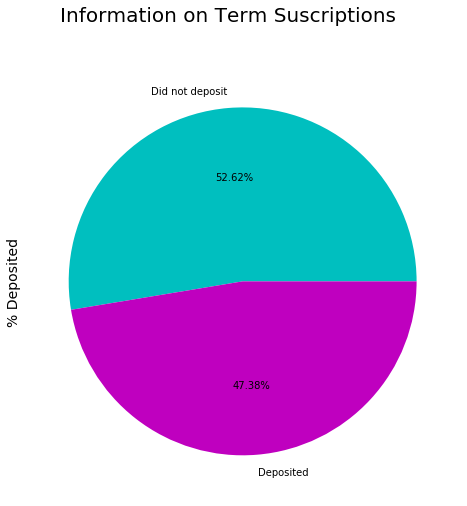

In [7]:
plt.figure(figsize=(16,8))
labels ="Did not deposit", "Deposited"
colors = ['c', 'm']
plt.suptitle('Information on Term Suscriptions', fontsize=20)
plt.pie(df_raw["deposit"].value_counts(),autopct='%1.2f%%', labels=labels, colors=colors)
plt.ylabel('% Deposited', fontsize=14)

Distribution of numerical data

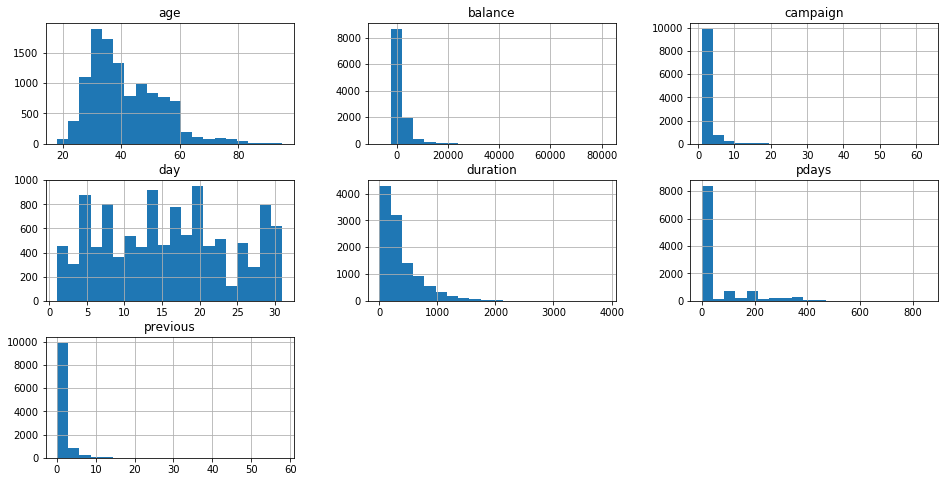

In [8]:
df_raw.hist(bins=20, figsize=(16,8))
plt.show()

Hunch is that jobs impact likelihood of subscribing to term deposit.

Let's remove "unknown" job.

In [9]:
df_raw = df_raw.drop(df_raw.loc[df_raw.job=="unknown"].index)

And replace "admin" with management since fairly similar.

In [10]:
df_raw.job = df_raw.job.replace("admin.", "management")

In [11]:
df_raw.job.value_counts()

management       3900
blue-collar      1944
technician       1823
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

Let's see correlations

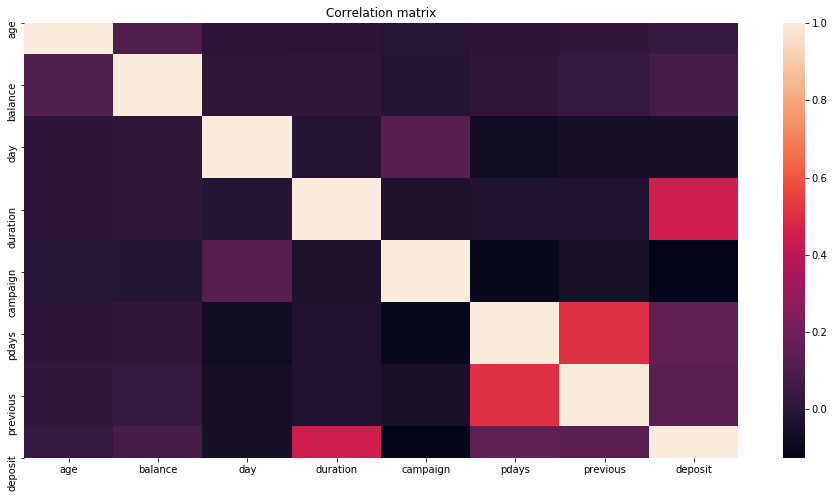

In [12]:
#need to one-hot encode our target variable
from sklearn.preprocessing import LabelEncoder

fig=plt.figure(figsize=(16,8))
df_raw.deposit = LabelEncoder().fit_transform(df_raw.deposit)

#we can only use numerical features for correlation analysis
numeric_df_raw = df_raw.select_dtypes(exclude="object")

cor_diagram = numeric_df_raw.corr()

sns.heatmap(cor_diagram, cbar=True)
plt.title("Correlation matrix")
plt.show()

From here, we see campaign last contact duration has the highest correlation with whether or not a person subscribes for a deposit.

In [13]:
df_raw["duration_status"] = np.nan

avg_duration = df_raw["duration"].mean()

df_raw["duration_status"] = df_raw.apply(lambda row: "below_average" if row.duration<avg_duration else "above_average",axis=1 )

yes_no_by_durationstatus = pd.crosstab(df_raw['duration_status'], df_raw['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_durationstatus

deposit,0,1
duration_status,,
above_average,22.63,77.37
below_average,68.34,31.66


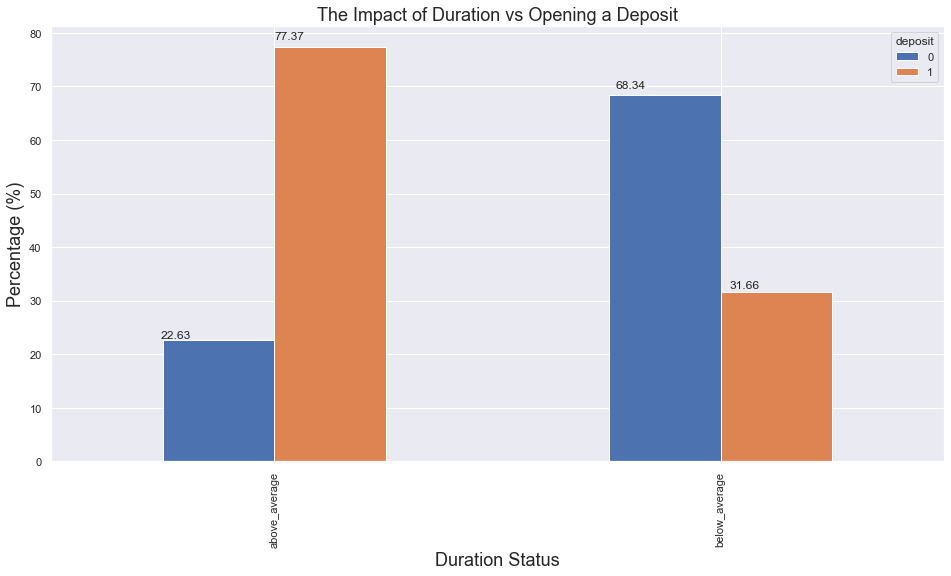

In [14]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_durationstatus.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration vs Opening a Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From here, we see that if you had an above average duration since last campaign, and you were contacted again, majority would subscribe. Conversely, if it hasnt been that long since you were last contacted, and you were contacted again, majority would not subscribe to a deposit.

Probably best to not contact people who have recently been reached out to, focus on those we have not reached out to in a while.

## 3. Model data

In [15]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [16]:
df_full[df_full.age.isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit


### Split train - test

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for training_data_indexes, test_data_indexes in stratifier.split(df_full,df_full.loan):
    stratified_training_data = df_full.loc[training_data_indexes]
    stratified_test_data = df_full.loc[test_data_indexes]
    
    
#create copies
train = stratified_training_data
test = stratified_test_data

In [18]:
train.shape

(8929, 17)

In [19]:
test.shape

(2233, 17)

### Build transformation pipeline

In [20]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.
# Code reference Hands on Machine Learning with Scikit Learn and Tensorflow by Aurelien Geron.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8929 entries, 9867 to 9672
Data columns (total 17 columns):
age          8929 non-null int64
job          8929 non-null object
marital      8929 non-null object
education    8929 non-null object
default      8929 non-null object
balance      8929 non-null int64
housing      8929 non-null object
loan         8929 non-null object
contact      8929 non-null object
day          8929 non-null int64
month        8929 non-null object
duration     8929 non-null int64
campaign     8929 non-null int64
pdays        8929 non-null int64
previous     8929 non-null int64
poutcome     8929 non-null object
deposit      8929 non-null object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


In [23]:
train.shape

(8929, 17)

In [24]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
numeric_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [25]:
categoric_cols = train.select_dtypes(exclude=np.number).columns.tolist()
#remove target variable, to ensure that we end up with feature set, not label
categoric_cols.remove('deposit')
categoric_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [26]:
# Build pipelines to scale numerical features and encode categorical

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_cols)),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(categoric_cols)),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [27]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [28]:
#instantiatie label from stratified datasets
y_train = train['deposit']
y_test = test['deposit']
y_train.shape

(8929,)

In [29]:
# encode label
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

### Train using cross-val

In [32]:
#Creat dict of classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict


dict_clf_class = {
    'logistic_reg': LogisticRegression(),
    'support_vector_clf': SVC(),
    'knn_clf': KNeighborsClassifier(),
    'gradient_boosting_clf': GradientBoostingClassifier(),
    'random_forest_cld': RandomForestClassifier(),
    'naive_bayes_clf': GaussianNB()
}

dict_clf_preds = {}

clf_list, clf_score = [], []

for classifier in dict_clf_class.keys():
    this_score = cross_val_score(dict_clf_class[classifier], X_train, y_train, cv=5)
    this_mean = this_score.mean()
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
    dict_clf_preds[classifier] = cross_val_predict(dict_clf_class[classifier], X_train, y_train, cv=5) #get predictions, for ROC curve
    print(classifier, this_mean)

logistic_reg 0.8265229583719329
support_vector_clf 0.8418654490335585
knn_clf 0.8047939130884586
gradient_boosting_clf 0.8469070896405568
random_forest_cld 0.8226070327403485
naive_bayes_clf 0.7192280381654621


On just rmse evaluation, GB classifier appears to perform the best but only marginally better than an svm. 

### Evaluate precision-recall using AUC in ROC.

In [33]:
# https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

from sklearn.metrics import roc_auc_score

for classifier in dict_clf_preds.keys():
    print('{}: {}'.format(classifier, roc_auc_score(y_train, dict_clf_preds[classifier])))

logistic_reg: 0.8250485066082078
support_vector_clf: 0.8422523043908894
knn_clf: 0.8025489764813883
gradient_boosting_clf: 0.8474285812888651
random_forest_cld: 0.8236482191303381
naive_bayes_clf: 0.7115825348843104


Looking at precision-recall curve, again svm and GB classifier are close.

### Use XG Boost